In [ ]:
def Verify(expression: bool, message: str):
    if not expression:
        raise Exception(message)
    else:
        return

<h1>Task 1.1: IMDB Data loading</h1>

In [ ]:
import numpy as np

class IMDBSample:
    def __init__(self, rowIndex, numberOfFeatures=89527):
        self.rowIndex = rowIndex
        self.features = np.zeros(numberOfFeatures)
        self.label = -1

class IMDBDataLoader:
    def __init__(self, vocabFilepath, featFilepath):
        self.samples = []
        self.words = []
        self.vocabFilepath = vocabFilepath
        self.featFilepath = featFilepath
        self.ParseIntoVectors()
    
    def ParseIntoVectors(self):
        with open(self.featFilepath, 'r', encoding='utf-8') as file:
            for line_number, line in enumerate(file, start=0):
                currentSample = IMDBSample(line_number)
                parts = line.split()
                Verify(int(parts[0])>6 or int(parts[0]) < 6, "Error: Rating value unexpected in IMDB dataloader.")
                currentSample.label = int(int(parts[0]))
                for part in parts[1:]:
                    wordIndex, frequency = map(int, part.split(':'))
                    Verify(wordIndex<currentSample.features.size, "Word index larger than number of features in IMDB dataloader")
                    Verify(frequency>=0, "Word Frequency is smaller than expected in IMDB dataloader.")
                    currentSample.features[wordIndex] = frequency
                self.samples.append(currentSample)

        with open(self.vocabFilepath, 'r', encoding='utf-8') as file:
            for line_number, line in enumerate(file, start = 0):
                self.words.append(line)
                
    
    def GetData(self):
        numberOfSamples = len(self.samples)
        numberOfFeatures = self.samples[0].features.size if self.samples else 0

        X = np.zeros((numberOfSamples, numberOfFeatures))
        y = np.zeros(numberOfSamples)

        for i, sample in enumerate(self.samples):
            X[i,:] = sample.features
            y[i] = sample.label
        return y, X
    
    def GetWords(self):
        return self.words

<h3>Data loading</h3>

In [ ]:
vocabFilepath = '../aclImdb/imdb.vocab'
trainfeatFilepath = '../aclImdb/train/labeledBow.feat'
testfeatFilepath = '../aclImdb/test/labeledBow.feat'
dataloaderTrain = IMDBDataLoader(vocabFilepath, trainfeatFilepath)
dataloaderTest = IMDBDataLoader(vocabFilepath, testfeatFilepath)
print("Dataloading complete")
y_train, X_train = dataloaderTrain.GetData()
y_test, X_test = dataloaderTest.GetData()

words = dataloaderTrain.GetWords()


<h3>Data filtering</h3>

In [ ]:
onePercentThreshold = int(y_train.size*0.01)
fiftyPercentThreshold = int(y_train.size*0.5)
featureFrequencies = np.sum(X_train > 0, axis=0)

featuresToKeep = (featureFrequencies > onePercentThreshold) & (featureFrequencies < fiftyPercentThreshold)
featureFrequenciesFiltered = featureFrequencies[featuresToKeep]
XFiltered_train = X_train[:, featuresToKeep]
XFiltered_test = X_test[:, featuresToKeep]
wordsFiltered = [word for word, keep in zip(words, featuresToKeep) if keep]

weights = np.linalg.inv(XFiltered_train.T @ XFiltered_train) @ XFiltered_train.T @ y_train #OLS SSE Solution
D_Selected = 1000
feature_importances = np.abs(np.copy(weights))
top_features_indices = np.argsort(feature_importances)[-D_Selected:]
XFiltered_train_selected = XFiltered_train[:, top_features_indices]
XFiltered_test_selected = XFiltered_test[:, top_features_indices]
featureFrequenciesFiltered_Selected = featureFrequenciesFiltered[top_features_indices]
wordsFiltered_selected = [wordsFiltered[i] for i in top_features_indices]

<h3>Displaying Top Words (Task 3.1)</h3>

In [ ]:
numberOfWordsToDisplay = 10 #both positive and negative side
positive_weights_indices = np.argsort(weights)[-numberOfWordsToDisplay:]
negative_weights_indices = np.argsort(weights)[:numberOfWordsToDisplay]
words_with_largest_positive_weights = [(wordsFiltered[i].strip(), weights[i], featureFrequenciesFiltered[i]) for i in positive_weights_indices]
words_with_largest_negative_weights = [(wordsFiltered[i].strip(), weights[i], featureFrequenciesFiltered[i]) for i in negative_weights_indices]

print(f"Words with the {numberOfWordsToDisplay} largest positive weights:")
for word, weight, frequency in reversed(words_with_largest_positive_weights):
    print(f"Word: '{word}', Weight: {weight:.5f}, Frequency: {frequency}")

print("\n")

print(f"Words with the {numberOfWordsToDisplay} largest negative weights:")
for word, weight, frequency in words_with_largest_negative_weights:
    print(f"Word: '{word}', Weight: {weight:.5f}, Frequency: {frequency}")

<h1>Logistic Regression</h1>

In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class CE_Loss:
    def set_data(self, y_true, X):
        self.y_true = y_true
        self.X = X
    
    def __call__(self, w):
        a = self.X@w
        # y_pred = 1/(1+np.exp(-a))
        # return -np.mean(self.y_true*np.log(y_pred)-(1-self.y_true)*np.log(1-y_pred))
        ###Equivalently for precision and numerical stability (slide 9/37 logistic regression)###
        return np.mean(self.y_true*np.log1p(np.exp(-a)) +(1-self.y_true)*np.log1p(np.exp(a)))
    
    def grad(self, w):
        a = self.X@w
        y_pred = 1/(1+np.exp(-a))
        return self.X.T@(y_pred-self.y_true)/self.y_true.size
        
#minimizes
class Gradient_Descent:
    def __init__(self, weights, learning_rate, max_iter, epsilon, cost_function):
        self.weights = weights
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.cost_acc = []
        self.epsilon = epsilon
        self.f = cost_function

    def optimize(self):
        initial_cost = self.f(self.weights)
        self.cost_acc.append(initial_cost)

        for i in range(self.max_iter):
            self.weights -= self.f.grad(self.weights)
            new_cost = self.f(self.weights)
            # print(f"Iteration{i+1} \t Cost: {new_cost}") #Toggle
            self.cost_acc.append(new_cost)
            delta = new_cost-self.cost_acc[i]
            if (np.abs(delta)<self.epsilon):
                return new_cost
        return new_cost
            

class Binary_Logitstic_Regression:
    def __init__(self, learning_rate = 0.1, max_iter=1000, epsilon=1e-6, cost_function=CE_Loss()):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.f = cost_function

    def fit(self, X, y):
        self.X = X
        self.y = (y>5).astype(int) #Turn to binary immediately
        self.weights = np.ones(X.shape[1])
        self.f.set_data(self.y, self.X)
        optimizer = Gradient_Descent(self.weights, self.learning_rate, self.max_iter, self.epsilon, self.f)
        optimizer.optimize()
    
    def predict(self, X):
        Verify(self.weights.shape[0]>0, "Weights not optimized yet")
        return 1/(1+np.exp(-X@self.weights))
    
def perform_roc_and_auroc(predicted_probabilities, true_binary_labels):
    if predicted_probabilities.shape != true_binary_labels.shape:
        raise ValueError("Shapes of predicted probabilities and true labels must match.")
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(true_binary_labels, predicted_probabilities)
    
    # Calculate the AUROC
    auroc = auc(fpr, tpr)
    roc_curve_data = (fpr, tpr, thresholds)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    return auroc, roc_curve_data


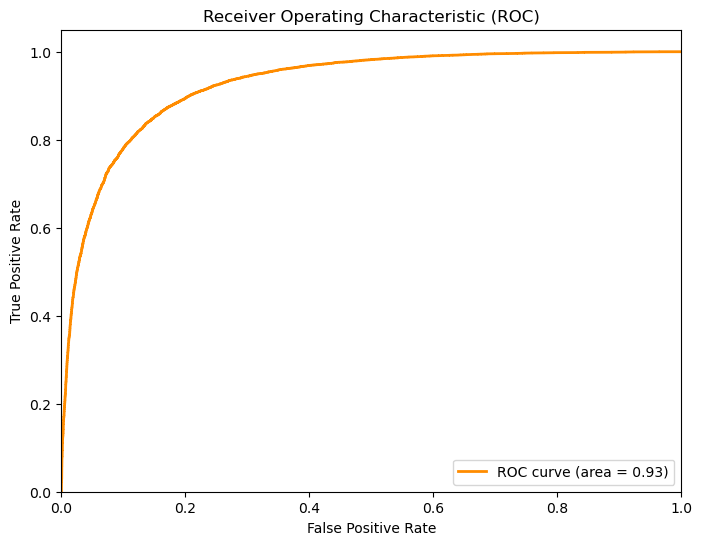

In [52]:
regressionObject = Binary_Logitstic_Regression()
regressionObject.fit(XFiltered_train_selected, y_train)
test_output = regressionObject.predict(XFiltered_test_selected)
auroc, roc_curve_data = perform_roc_and_auroc(test_output, (y_test>5).astype(int))

<h3>Working in a train/val split</h3>

In [53]:
#minimizes
class Gradient_Descent_With_Validation:
    def __init__(self, weights, learning_rate, max_iter, epsilon, train_cost_function, validation_cost_function):
        self.weights = weights
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.train_cost_acc = []
        self.val_cost_acc = []
        self.epsilon = epsilon
        self.ftrain = train_cost_function
        self.fval = validation_cost_function

    def optimize(self):
        initial_train_cost = self.ftrain(self.weights)
        self.train_cost_acc.append((0,initial_train_cost))
        initial_val_cost = self.fval(self.weights)
        minimum_val_cost = initial_val_cost
        self.val_cost_acc.append((0,initial_val_cost))
        best_weights = np.copy(self.weights) #Will hold the weights from the lowest validation score

        for i in range(self.max_iter):
            #VALIDATION
            if i%10 ==0:
                current_val_cost = self.fval(self.weights)
                self.val_cost_acc.append((i, current_val_cost))
                if current_val_cost<minimum_val_cost:
                    minimum_val_cost = current_val_cost
                    best_weights = np.copy(self.weights)

            #TRAINING
            self.weights -= self.ftrain.grad(self.weights)
            new_cost = self.ftrain(self.weights)
            self.train_cost_acc.append((i,new_cost))
            delta = new_cost-self.train_cost_acc[i][1]
            if (np.abs(delta)<self.epsilon):
                return best_weights
            
        return best_weights
            

class Binary_Logitstic_Regression_With_Validation:
    def __init__(self, learning_rate = 0.1, max_iter=5000, epsilon=1e-6, validation_fraction = 0.2, random_state = 69, train_cost_function=CE_Loss(), val_cost_function = CE_Loss()):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.validation_fraction = validation_fraction
        self.random_state=random_state
        self.ftrain = train_cost_function
        self.fval = val_cost_function

    def fit(self, X, y):
        y = (y>5).astype(int) #Turn to binary immediately
        np.random.seed(self.random_state)
        total_samples = X.shape[0]
        val_size = int(total_samples*self.validation_fraction)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        initialWeights = np.ones(X.shape[1])
        self.ftrain.set_data(y_train, X_train)
        self.fval.set_data(y_val, X_val)
        optimizer = Gradient_Descent_With_Validation(initialWeights, self.learning_rate, self.max_iter, self.epsilon, self.ftrain, self.fval)
        self.weights = optimizer.optimize()
        return optimizer.train_cost_acc, optimizer.val_cost_acc
    
    def predict(self, X):
        Verify(self.weights.shape[0]>0, "Weights not optimized yet")
        return 1/(1+np.exp(-X@self.weights))


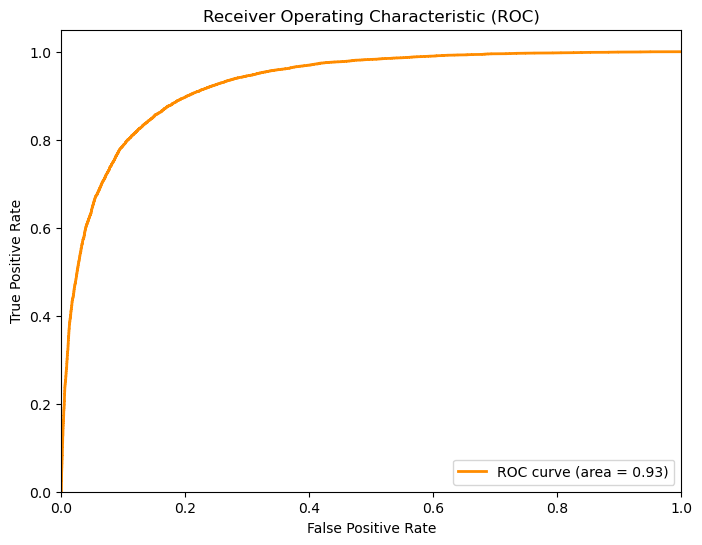

In [54]:
regressionObject = Binary_Logitstic_Regression_With_Validation()
train_costs, val_costs = regressionObject.fit(XFiltered_train_selected, y_train)
test_output = regressionObject.predict(XFiltered_test_selected)
auroc, roc_curve_data = perform_roc_and_auroc(test_output, (y_test>5).astype(int))

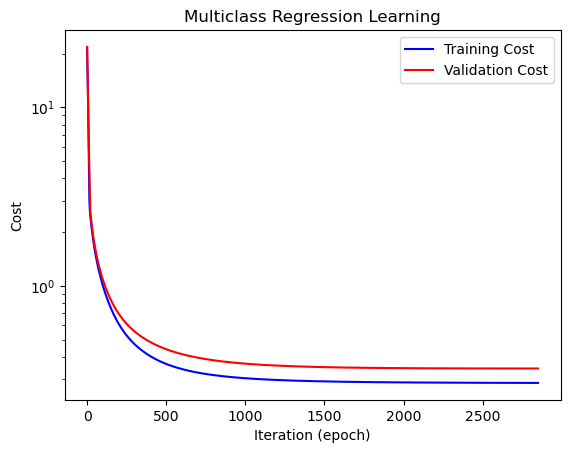

In [55]:
#Plotting train, val costs
import matplotlib.pyplot as plt
skipFirstN = 0
x1, y1 = zip(*train_costs[skipFirstN:])
x2, y2 = zip(*val_costs[skipFirstN:])
plt.plot(x1,y1, color='blue', label='Training Cost')
plt.plot(x2, y2, color='red', label = 'Validation Cost')
plt.title('Multiclass Regression Learning')
plt.xlabel('Iteration (epoch)')
plt.ylabel('Cost')
plt.yscale('log')
plt.legend()
plt.show()

<h1> Task 1.2: 20 News Groups </h1>

In [ ]:
#Clearing all local variables
%reset -f

import numpy as np
from sklearn import datasets

#also the one hot encoding template
categories = ['rec.autos', 'rec.sport.hockey', 'sci.med', 'talk.politics.mideast', 'comp.graphics']

bunchTrain = datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
bunchTest = datasets.fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)
y_train = bunchTrain.target
y_test = bunchTest.target

# print(len(bunchTrain.data)) #2936
# print(len(bunchTest.data)) #1956

#We now need to convert the text data from bunch[Train or Test].data to a vector representation 
#Following guide in https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#We first tokenize with CountVectorizer so that we have vectors of the occurrences of the different words
#The index of the value (occurrence) in the feature vector for a given sample is associated to the order of appearance of a certain word over all samples
#So if we have three samples ["Hello my name"] ["is zach and"] ["i like chicken"]
#Our feature vectors each be of length 9 where the indices correspond to the occurence of ["hello", "my", "name", "is", "zach", "and", "i", "like","chicken"]
#So our samples will be [1,1,1,0,0,0,0,0,], [0,0,0,1,1,1,0,0,0] and [0,0,0,0,0,0,1,1,1]

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(bunchTrain.data) #Count vectorizer also supposedly filters stopwords
X_test_counts = count_vect.transform(bunchTest.data) #We transform from the fitted transform on the training data so that our test data feature vectors are the same encoding - ie use the same index-word pairings. Otherwise the weights will not be aligned to the same words

print(X_train_counts.shape)
print(X_test_counts.shape)

#Now we the same 1% and 50% thresholds to reduce our dimensionality
#binary vect in NxD but binary (1 means word is in sample, 0 means no)
binary_vect = CountVectorizer(binary=True)
X_train_binary = binary_vect.fit_transform(bunchTrain.data)
wordFrequencies = np.asarray(np.sum(X_train_binary,axis=0)).squeeze() #ie number of samples containing a word
onePercentThreshold = 0.01*y_train.shape[0]
fiftyPercentThreshold = 0.50*y_train.shape[0]
featuresToKeep = np.where((wordFrequencies > onePercentThreshold) & (wordFrequencies < fiftyPercentThreshold)
)[0]
X_train_filtered = X_train_counts[:,featuresToKeep]
X_test_filtered = X_test_counts[:,featuresToKeep]
words_filtered = [word for word, idx in count_vect.vocabulary_.items() if idx in featuresToKeep]

print(X_train_filtered.shape)
print(X_test_filtered.shape)
print(len(words_filtered))

#Now to get the most important K features, we can use SelectKBest and mutual_info_calssif
#View the tutorial linked above (scikit)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
k = 1000 #Number of final dimensions
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_filtered, y_train)

X_train_selected = selector.transform(X_train_filtered)
X_test_selected = selector.transform(X_test_filtered)

selected_features_mask = selector.get_support(indices=True)
words_selected = [words_filtered[i] for i in selected_features_mask]

print(X_train_selected.shape)
print(X_test_selected.shape)
print(len(words_selected))
print(y_train.shape)
print(y_test.shape)


#Now we apply one hot encoding
num_classes = len(categories)
y_train_encoded = np.zeros((y_train.size, num_classes)) #initializing empty matrices
y_test_encoded = np.zeros((y_test.size, num_classes))
y_train_encoded[np.arange(y_train.size), y_train] =1 #populating
y_test_encoded[np.arange(y_test.size), y_test] =1

print(y_train_encoded.shape)
print(y_test_encoded.shape)

<h2>Multi-class Regression</h2>

In [56]:
#Same as earlier, just copied so we don't have to rerun every cell everytime
class Gradient_Descent:
    def __init__(self, weights, learning_rate, max_iter, epsilon, cost_function):
        self.weights = weights
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.cost_acc = []
        self.epsilon = epsilon
        self.f = cost_function

    def optimize(self):
        initial_cost = self.f(self.weights)
        self.cost_acc.append(initial_cost)

        for i in range(self.max_iter):
            self.weights -= self.f.grad(self.weights)
            new_cost = self.f(self.weights)
            # print(f"Iteration{i+1} \t Cost: {new_cost}") #Toggle
            self.cost_acc.append(new_cost)
            delta = new_cost-self.cost_acc[i]
            if (np.abs(delta)<self.epsilon):
                return new_cost
        return new_cost

class MultiClass_CE_Loss:
    def set_data(self, X, y_true, numerical_stability = 1e-9):
        #X is NxD
        #y_true is NxC (one hot encoded)
        self.X = X
        self.y_true = y_true
        self.numerical_stability = numerical_stability

    #Softmax implementation uses a numerical stabilitiy trick of subtracting the maximum logit from each
    #https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning
    #Found online
    def softmax(self, logits):
        #Logits is NxC
        expLogits = np.exp(logits-np.max(logits, axis=1, keepdims=True)) #NxC
        sumExp = np.sum(expLogits, axis=1, keepdims=True) #Nx1
        probabilities = expLogits/sumExp #NxC
        return probabilities #NxC
    
    #Evaluates cross entropy from the self.X, self.y_true and the weights input as argument
    def __call__(self, w):
        #W is DxC
        logits = self.X@w #NxC
        probabilities = self.softmax(logits) #NxC
        cross_entropies = -np.sum(self.y_true * np.log(probabilities + self.numerical_stability), axis=1) #Nx1
        return np.mean(cross_entropies) #1x1
    
    #Gets probabilities from an X input (used for the test dataset)
    def get_probabilities(self, X, w):
        logits = X@w #NxC
        probabilities = self.softmax(logits) #NxC
        return probabilities
    
    #Returns the gradient from the self.x, self.y_true and the weights input as argument
    def grad(self, w):
        logits = self.X@w #NxC
        probabilities = self.softmax(logits) #NxC
        y_pred_minus_y_true = probabilities - self.y_true #element wise, NxC
        return self.X.T@(y_pred_minus_y_true)/self.X.shape[0] #DxN * NxC = DxC, averaged gradient rather than sum of gradient at each sample
    
class MultiClass_Regression:
    def __init__(self, learning_rate = 0.1, max_iter=15000, epsilon=1e-6, cost_function=MultiClass_CE_Loss()):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.f = cost_function

    def fit(self, X, y):
        self.weights = np.ones((X.shape[1], y.shape[1],), dtype=float) #DxC
        self.f.set_data(X, y)
        optimizer = Gradient_Descent(self.weights, self.learning_rate, self.max_iter, self.epsilon, self.f)
        optimizer.optimize()
    
    #Returns NxC probabilities matrix
    def predict(self, X):
        assert self.weights.shape[0]>0, "Weights not optimized yet"
        return self.f.get_probabilities(X, self.weights)
    
#Proababilities NxC, y_true NxC one hot encoded
def compute_classification_accuracy(probabilities, y_true):
    predicted_classes = np.argmax(probabilities, axis=1) #Nx1 (0,1,2,3,4, etc)
    true_classes = np.argmax(y_true, axis=1) #Nx1 (0,1,2,3,4,etc)
    correct_predictions = np.sum(predicted_classes == true_classes) #1x1
    total_samples = probabilities.shape[0] #N
    accuracy = correct_predictions / total_samples
    return accuracy*100 #returns as percentage, not decimal



In [57]:
multiclassregression = MultiClass_Regression()
multiclassregression.fit(X_train_selected, y_train_encoded)
predictions = multiclassregression.predict(X_test_selected)
accuracy = compute_classification_accuracy(predictions, y_test_encoded)
print(f"Classification Accuracy: {accuracy:.2f}%") #75.46% observed

Classification Accuracy: 75.46%


<h1>Now that everythings implemented, let's work in a train/val split to avoid overfitting</h1>

In [58]:
#Same as earlier, just copied so we don't have to rerun every cell everytime
class Gradient_Descent_With_Validation:
    def __init__(self, weights, learning_rate, max_iter, epsilon, train_cost_function, validation_cost_function):
        self.weights = weights
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.train_cost_acc = []
        self.val_cost_acc = []
        self.epsilon = epsilon
        self.ftrain = train_cost_function
        self.fval = validation_cost_function

    def optimize(self):
        initial_train_cost = self.ftrain(self.weights)
        self.train_cost_acc.append((0,initial_train_cost))
        initial_val_cost = self.fval(self.weights)
        minimum_val_cost = initial_val_cost
        self.val_cost_acc.append((0,initial_val_cost))
        best_weights = np.copy(self.weights) #Will hold the weights from the lowest validation score

        for i in range(self.max_iter):
            #VALIDATION
            if i%10 ==0:
                current_val_cost = self.fval(self.weights)
                self.val_cost_acc.append((i, current_val_cost))
                if current_val_cost<minimum_val_cost:
                    minimum_val_cost = current_val_cost
                    best_weights = np.copy(self.weights)

            #TRAINING
            self.weights -= self.ftrain.grad(self.weights)
            new_cost = self.ftrain(self.weights)
            self.train_cost_acc.append((i,new_cost))
            delta = new_cost-self.train_cost_acc[i][1]
            if (np.abs(delta)<self.epsilon):
                return best_weights
            
        return best_weights
    

class MultiClass_Regression_With_Validation:
    def __init__(self, learning_rate = 0.1, max_iter=15000, epsilon=1e-6, validation_fraction = 0.2, random_state=69, train_cost_function=MultiClass_CE_Loss(), val_cost_function=MultiClass_CE_Loss()):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.validation_fraction = validation_fraction
        self.random_state=random_state
        self.train_cost_function = train_cost_function
        self.val_cost_function = val_cost_function

    def fit(self, X, y):
        #Splitting into training/validation
        np.random.seed(self.random_state)
        total_samples = X.shape[0]
        val_size = int(total_samples*self.validation_fraction)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        initialWeights = np.ones((X.shape[1], y.shape[1],), dtype=float) #DxC
        self.train_cost_function.set_data(X_train, y_train)
        self.val_cost_function.set_data(X_val, y_val)

        optimizer = Gradient_Descent_With_Validation(initialWeights, self.learning_rate, self.max_iter, self.epsilon, self.train_cost_function, self.val_cost_function)
        self.weights = optimizer.optimize()
        return optimizer.train_cost_acc, optimizer.val_cost_acc

    
    #Returns NxC probabilities matrix
    def predict(self, X):
        assert self.weights.shape[0]>0, "Weights not optimized yet"
        return self.train_cost_function.get_probabilities(X, self.weights)
    
multiclassregression = MultiClass_Regression_With_Validation()
train_costs, val_costs = multiclassregression.fit(X_train_selected, y_train_encoded)
predictions = multiclassregression.predict(X_test_selected)
accuracy = compute_classification_accuracy(predictions, y_test_encoded)
print(f"Classification Accuracy: {accuracy:.2f}%") #77.45% observed

Classification Accuracy: 77.45%


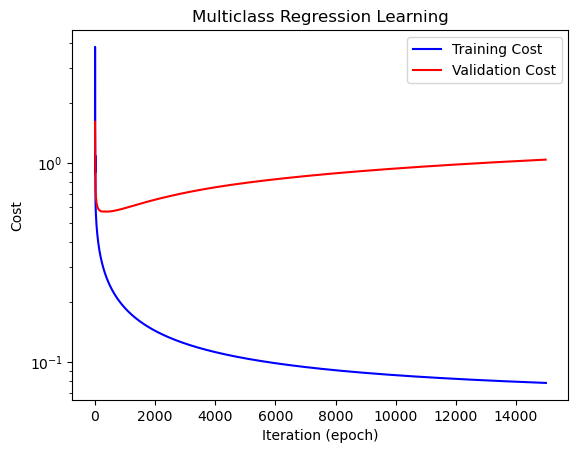

In [59]:
#Plotting train, val costs
import matplotlib.pyplot as plt
skipFirstN = 0
x1, y1 = zip(*train_costs[skipFirstN:])
x2, y2 = zip(*val_costs[skipFirstN:])
plt.plot(x1,y1, color='blue', label='Training Cost')
plt.plot(x2, y2, color='red', label = 'Validation Cost')
plt.title('Multiclass Regression Learning')
plt.xlabel('Iteration (epoch)')
plt.ylabel('Cost')
plt.yscale('log')
plt.legend()
plt.show() #plot shows clear overfitting, so its good that we save the parameters of the lowest validation score rather than lowest training score

<h2>Task 2.1 Testing Gradient</h2>

In [193]:
#Binary regression

np.random.seed(0)

#example data
N =1 #N must be 1 so that we can essentially get the gradient for only one sample
D = 1 #D must also be 1 so that we can essentially get the partial derivative of only one direction
X = np.random.rand(N,D)
y= np.random.randint(2, size=(N,1))
w = np.random.rand(D,1)

fbin = CE_Loss()
fbin.set_data(y_true=y, X=X)
analyticalGradient = fbin.grad(w)
pertubation = 1e-8
wpos = np.copy(w)+pertubation
wneg = np.copy(w)-pertubation
valpos = fbin(wpos)
valneg = fbin(wneg)
numericalGradient = (valpos-valneg)/(2*pertubation)
sum_of_squared_differences = np.sum((analyticalGradient-numericalGradient)**2)
print(f"Binary cross entropy analytical/numerical discrepancy: {sum_of_squared_differences}")


#Multiclass Regression

fmulti = MultiClass_CE_Loss()
fmulti.set_data(X, y_true=y)
analyticalGradient = fmulti.grad(w)
valpos = fmulti(wpos)
valneg = fmulti(wneg)
numericalGradient = (valpos-valneg)/(2*pertubation)
sum_of_squared_differences = np.sum((analyticalGradient-numericalGradient)**2)
print(f"Multiclass cross entropy analytical/numerical discrepancy: {sum_of_squared_differences}") #This can sometimes



Binary cross entropy analytical/numerical discrepancy: 4.460104795805558e-18
Multiclass cross entropy analytical/numerical discrepancy: 0.0
